In [111]:
import pandas as pd

# This cell reads our csv and extracts the information needed for calculations
def extract_close_prices(csv_file):
    try:
        df = pd.read_csv(csv_file, header=[0, 1, 2])
    except FileNotFoundError:
        print(f"Error: File not found at {csv_file}")
        return None
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

    
    date_column = ('Price', 'Ticker', 'Date')

    if date_column not in df.columns:
        print(f"Error: Could not find the 'Date' column with the MultiIndex {date_column}")
        print("Available columns:")
        print(df.columns)
        return None

    
    close_columns = [col for col in df.columns if col[0] == 'Close']

    if not close_columns:
        print("Error: Could not find 'Close' columns in the expected structure.")
        return None

    
    date_series = df[date_column]

    
    close_data = {'Date': date_series}

    
    for close_col in close_columns:
        ticker = close_col[1]
        close_data[ticker] = df[close_col]

    
    close_df = pd.DataFrame(close_data)

    
    close_df['Date'] = pd.to_datetime(close_df['Date'])


    close_df.set_index('Date', inplace=True)

    return close_df

file_path = 'C:/Users/jeell/OneDrive/Documents/GitHub/Final_Project/precious_metals_data.csv'
close_prices_df = extract_close_prices(file_path)

if close_prices_df is not None:
    print("Close prices DataFrame loaded successfully.")
    print(close_prices_df.head())
else:
    print("Error loading close prices DataFrame.")

Close prices DataFrame loaded successfully.
                   GC=F        PA=F         PL=F       SI=F
Date                                                       
2010-01-04  1117.699951  419.799988  1517.300049  17.440001
2010-01-05  1118.099976  420.350006  1530.800049  17.781000
2010-01-06  1135.900024  425.600006  1552.199951  18.163000
2010-01-07  1133.099976  422.950012  1553.000000  18.333000
2010-01-08  1138.199951  424.149994  1564.599976  18.458000


Correlation heatmap saved to correlation_heatmap.png


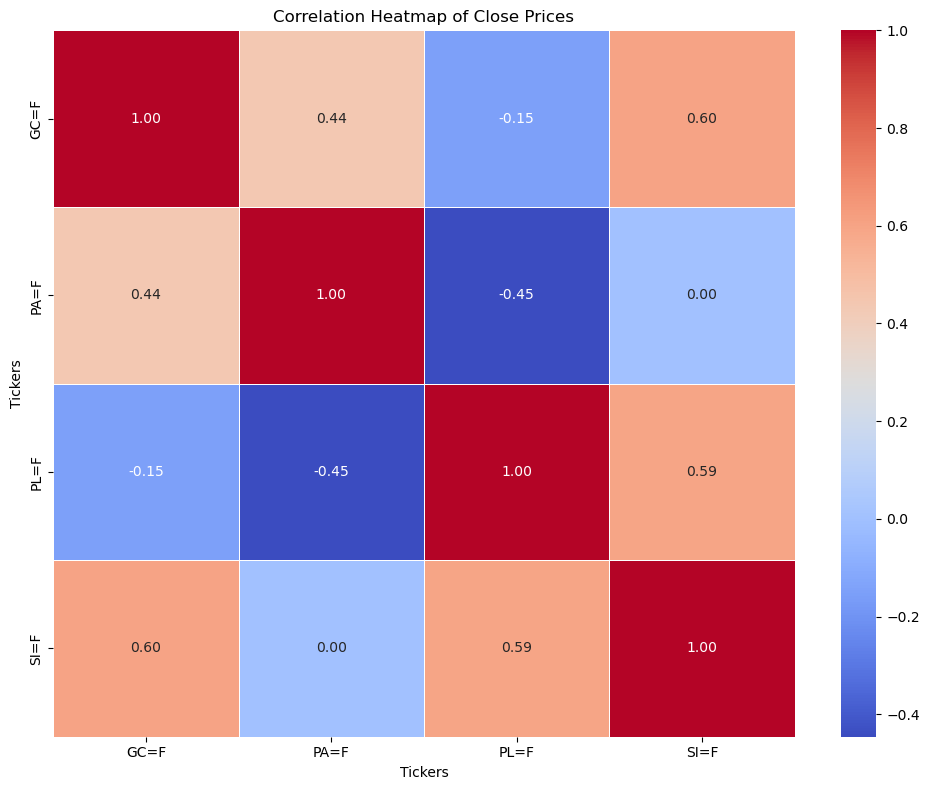

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# This cell calculates, plots, and saves the plot of the correlation coefficients
def plot_correlation_heatmap(df, filename="correlation_heatmap.png"):
   
    if df is None or df.empty:
        print("Error: Input DataFrame is empty or None. Cannot plot correlation heatmap.")
        return


    correlation_matrix = df.corr()

    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Close Prices')
    plt.xlabel('Tickers')
    plt.ylabel('Tickers')
    plt.tight_layout()

    
    plt.savefig(filename)
    print(f"Correlation heatmap saved to {filename}")
    plt.show()


if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    plot_correlation_heatmap(close_prices_df)
else:
    print("Error: The 'close_prices_df' DataFrame is not available. Please run the data loading and extraction part first.")

In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# This finds the linear regression 10 years train data and 5 years test data and plots and saves the forecast
def forecast_and_evaluate_ticker(df, ticker, train_years=10, test_years=5, forecast_years=5, filename=None):

    if ticker not in df.columns:
        print(f"Error: Ticker '{ticker}' not found in the DataFrame.")
        return None, None

    ticker_data = df[ticker].dropna()
    if ticker_data.empty:
        print(f"Error: No valid data found for ticker '{ticker}'.")
        return None, None

    dates = ticker_data.index
    numerical_dates = (dates - dates[0]).days.values.reshape(-1, 1)
    prices = ticker_data.values

    
    if not dates.empty:
        start_date = dates.min()
        train_end_date = start_date + pd.DateOffset(years=train_years)
        test_end_date = train_end_date + pd.DateOffset(years=test_years)

        train_data = ticker_data[dates < train_end_date]
        test_data = ticker_data[(dates >= train_end_date) & (dates < test_end_date)]
    else:
        print(f"Error: No date information available for ticker '{ticker}'.")
        return None, None

    if train_data.empty or test_data.empty:
        print(f"Warning: Not enough data for training and testing with {train_years} and {test_years} years for {ticker}.")
        return None, None

    X_train_dates_num = (train_data.index - dates[0]).days.values.reshape(-1, 1)
    y_train = train_data.values
    X_test_dates_num = (test_data.index - dates[0]).days.values.reshape(-1, 1)
    y_test = test_data.values

    
    model = LinearRegression()
    model.fit(X_train_dates_num, y_train)

    
    y_pred_test = model.predict(X_test_dates_num)
    mse = mean_squared_error(y_test, y_pred_test)

    
    last_date = dates[-1]
    forecast_start_date = last_date  # Start forecast from the last data point
    forecast_end_date = forecast_start_date + pd.DateOffset(years=forecast_years)

    forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
    numerical_forecast_dates = (forecast_dates - dates[0]).days.values.reshape(-1, 1)

    
    y_forecast = model.predict(numerical_forecast_dates)
    forecast_df = pd.DataFrame({'Date': forecast_dates, f'{ticker}_Forecast': y_forecast}).set_index('Date')

    
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, y_train, label=f'Training Data ({train_years} Years)')
    plt.plot(test_data.index, y_test, label=f'Testing Data ({test_years} Years)')
    plt.plot(test_data.index, y_pred_test, label='Test Predictions', linestyle='--')
    plt.plot(forecast_dates, y_forecast, label=f'{forecast_years}-Year Forecast', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Linear Regression Forecast for {ticker} (MSE = {mse:.2f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    
    if filename is None:
        filename = f'{ticker}_linear_regression_forecast.png'
    plt.savefig(filename)
    print(f"Forecast plot for {ticker} saved to {filename}")
    plt.close()

    return forecast_df, mse


if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    
    tickers = [col for col in close_prices_df.columns]

    all_forecasts = {}
    all_mses = {}

    for ticker in tickers:
        print(f"\n--- Forecasting for {ticker} ---")
        forecast_filename = f'{ticker}_forecast_10yr_train.png'
        forecast_data, test_mse = forecast_and_evaluate_ticker(
            close_prices_df, ticker, filename=forecast_filename
        )

        if forecast_data is not None and test_mse is not None:
            all_forecasts[ticker] = forecast_data
            all_mses[ticker] = test_mse
            print("\nForecast Data:")
            print(forecast_data.head())
            print(f"Mean Squared Error (Test Set): {test_mse:.2f}")
        else:
            print(f"Forecasting failed for {ticker}.")

    print("\n--- Summary of Forecasts ---")
    for ticker, mse in all_mses.items():
        print(f"Ticker: {ticker}, Test MSE: {mse:.2f}")

else:
    print("Error: The 'close_prices_df' DataFrame is not available. Please run the data loading and extraction part first.")


--- Forecasting for GC=F ---
Forecast plot for GC=F saved to GC=F_forecast_10yr_train.png

Forecast Data:
            GC=F_Forecast
Date                     
2024-12-31    1155.312475
2025-01-01    1155.259973
2025-01-02    1155.207471
2025-01-03    1155.154969
2025-01-04    1155.102467
Mean Squared Error (Test Set): 627640.69

--- Forecasting for PA=F ---
Forecast plot for PA=F saved to PA=F_forecast_10yr_train.png

Forecast Data:
            PA=F_Forecast
Date                     
2024-12-31    1533.728117
2025-01-01    1533.924182
2025-01-02    1534.120247
2025-01-03    1534.316312
2025-01-04    1534.512376
Mean Squared Error (Test Set): 658452.70

--- Forecasting for PL=F ---
Forecast plot for PL=F saved to PL=F_forecast_10yr_train.png

Forecast Data:
            PL=F_Forecast
Date                     
2024-12-31     190.548873
2025-01-01     190.258864
2025-01-02     189.968854
2025-01-03     189.678844
2025-01-04     189.388835
Mean Squared Error (Test Set): 300597.83

--- Forec

In [149]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# This calculates the AR by setting the mean to zero and only changing the lags
def forecast_autoregression_ticker(df, ticker, train_years=10, test_years=5, forecast_years=5, lags=5, filename=None):
    
    if ticker not in df.columns:
        print(f"Error: Ticker '{ticker}' not found in the DataFrame.")
        return None, None

    ticker_data = df[ticker].dropna()
    if ticker_data.empty:
        print(f"Error: No valid data found for ticker '{ticker}'.")
        return None, None

    dates = ticker_data.index

    
    if not dates.empty:
        start_date = dates.min()
        train_end_date = start_date + pd.DateOffset(years=train_years)
        test_end_date = train_end_date + pd.DateOffset(years=test_years)
        forecast_start_date = test_end_date
    else:
        print(f"Error: No date information available for ticker '{ticker}'.")
        return None, None

    train_data = ticker_data[dates < train_end_date]
    test_data = ticker_data[(dates >= train_end_date) & (dates < test_end_date)]

    if train_data.shape[0] < lags + 1 or test_data.empty:
        print(f"Warning: Not enough data for training ({len(train_data)} samples) or testing for {ticker} with {lags} lags.")
        return None, None

    
    try:
        model = ARIMA(train_data, order=(lags, 0, 0))
        model_fit = model.fit()

        
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        mse = mean_squared_error(test_data, predictions)

        
        forecast_result = model_fit.get_forecast(steps=(365 * forecast_years) + 1)
        forecast = forecast_result.predicted_mean
        forecast_dates = pd.date_range(start=dates[-1], periods=len(forecast), freq='D')
        forecast_df = pd.DataFrame({'Date': forecast_dates, f'{ticker}_Forecast_AR': forecast}).set_index('Date')

        
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data, label=f'Training Data ({train_years} Years)')
        plt.plot(test_data.index, test_data, label=f'Testing Data ({test_years} Years)')
        plt.plot(test_data.index, predictions, label=f'Test Predictions (AR({lags}))', linestyle='--')
        plt.plot(forecast_dates, forecast, label=f'{forecast_years}-Year Forecast (AR({lags}))', linestyle='-')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title(f'Auto Regression Forecast for {ticker} (MSE = {mse:.2f}, Lags = {lags})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        
        if filename is None:
            filename = f'{ticker}_autoreg_forecast_mse_{mse:.2f}_lags_{lags}.png'
        plt.savefig(filename)
        print(f"Auto Regression forecast plot for {ticker} saved to {filename}")
        plt.close()

        return forecast_df, mse

    except Exception as e:
        print(f"Error during Auto Regression for {ticker}: {e}")
        return None, None


if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    
    tickers = [col for col in close_prices_df.columns]

    all_ar_forecasts = {}
    all_ar_mses = {}
    ar_lags = 5  

    for ticker in tickers:
        print(f"\n--- Auto Regression Forecasting for {ticker} ---")
        forecast_filename = f'{ticker}_autoreg_forecast_10yr_train_lags_{ar_lags}.png'
        forecast_data, test_mse = forecast_autoregression_ticker(
            close_prices_df, ticker, lags=ar_lags, filename=forecast_filename
        )

        if forecast_data is not None and test_mse is not None:
            all_ar_forecasts[ticker] = forecast_data
            all_ar_mses[ticker] = test_mse
            print("\nAuto Regression Forecast Data:")
            print(forecast_data.head())
            print(f"Mean Squared Error (Test Set): {test_mse:.2f}")
        else:
            print(f"Auto Regression forecasting failed for {ticker}.")

    print("\n--- Summary of Auto Regression Forecasts ---")
    for ticker, mse in all_ar_mses.items():
        print(f"Ticker: {ticker}, Test MSE (AR({ar_lags})): {mse:.2f}")

else:
    print("Error: The 'close_prices_df' DataFrame is not available. Please run the data loading and extraction part first.")      

   

if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    
    tickers = [col for col in close_prices_df.columns]

    all_ar_forecasts = {}
    all_ar_mses = {}
    ar_lags = 10  

    for ticker in tickers:
        print(f"\n--- Auto Regression Forecasting for {ticker} ---")
        forecast_filename = f'{ticker}_autoreg_forecast_10yr_train_lags_{ar_lags}.png'
        forecast_data, test_mse = forecast_autoregression_ticker(
            close_prices_df, ticker, lags=ar_lags, filename=forecast_filename
        )

        if forecast_data is not None and test_mse is not None:
            all_ar_forecasts[ticker] = forecast_data
            all_ar_mses[ticker] = test_mse
            print("\nAuto Regression Forecast Data:")
            print(forecast_data.head())
            print(f"Mean Squared Error (Test Set): {test_mse:.2f}")
        else:
            print(f"Auto Regression forecasting failed for {ticker}.")

    print("\n--- Summary of Auto Regression Forecasts ---")
    for ticker, mse in all_ar_mses.items():
        print(f"Ticker: {ticker}, Test MSE (AR({ar_lags})): {mse:.2f}")

else:
    print("Error: The 'close_prices_df' DataFrame is not available. Please run the data loading and extraction part first.")


--- Auto Regression Forecasting for GC=F ---
Auto Regression forecast plot for GC=F saved to GC=F_autoreg_forecast_10yr_train_lags_5.png

Auto Regression Forecast Data:
            GC=F_Forecast_AR
Date                        
2024-12-31       1547.868464
2025-01-01       1547.286117
2025-01-02       1546.831015
2025-01-03       1545.961556
2025-01-04       1545.405423
Mean Squared Error (Test Set): 380830.33

--- Auto Regression Forecasting for PA=F ---
Auto Regression forecast plot for PA=F saved to PA=F_autoreg_forecast_10yr_train_lags_5.png

Auto Regression Forecast Data:
            PA=F_Forecast_AR
Date                        
2024-12-31       1953.758463
2025-01-01       1953.244223
2025-01-02       1952.189512
2025-01-03       1951.907565
2025-01-04       1951.698633
Mean Squared Error (Test Set): 288794.84

--- Auto Regression Forecasting for PL=F ---
Auto Regression forecast plot for PL=F saved to PL=F_autoreg_forecast_10yr_train_lags_5.png

Auto Regression Forecast Data:
  

In [151]:
# This finds the ARIMA 
def forecast_arima_ticker(df, ticker, train_years=10, test_years=5, forecast_years=5, order=(5, 1, 0), filename=None):
   
    if ticker not in df.columns:
        print(f"Error: Ticker '{ticker}' not found in the DataFrame.")
        return None, None

    ticker_data = df[ticker].dropna()
    if ticker_data.empty:
        print(f"Error: No valid data found for ticker '{ticker}'.")
        return None, None

    dates = ticker_data.index

    
    if not dates.empty:
        start_date = dates.min()
        train_end_date = start_date + pd.DateOffset(years=train_years)
        test_end_date = train_end_date + pd.DateOffset(years=test_years)
        forecast_start_date = test_end_date
    else:
        print(f"Error: No date information available for ticker '{ticker}'.")
        return None, None

    train_data = ticker_data[dates < train_end_date]
    test_data = ticker_data[(dates >= train_end_date) & (dates < test_end_date)]

    if len(train_data) < order[0] + order[2] + order[1] + 1 or test_data.empty:
        print(f"Warning: Not enough data for training ({len(train_data)} samples) or testing for {ticker} with ARIMA order {order}.")
        return None, None

    
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()

        
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        mse = mean_squared_error(test_data, predictions)

        
        forecast_result = model_fit.get_forecast(steps=(365 * forecast_years) + 1) # Add 1 to include the last point
        forecast = forecast_result.predicted_mean
        forecast_dates = pd.date_range(start=dates[-1], periods=len(forecast), freq='D') # Start from the last date
        forecast_df = pd.DataFrame({'Date': forecast_dates, f'{ticker}_Forecast_ARIMA': forecast}).set_index('Date')

        
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data, label=f'Training Data ({train_years} Years)')
        plt.plot(test_data.index, test_data, label=f'Testing Data ({test_years} Years)')
        plt.plot(test_data.index, predictions, label=f'Test Predictions (ARIMA{order})', linestyle='--')
        plt.plot(forecast_dates, forecast, label=f'{forecast_years}-Year Forecast (ARIMA{order})', linestyle='-')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title(f'ARIMA Forecast for {ticker} (MSE = {mse:.2f}, Order = {order})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        
        if filename is None:
            filename = f'{ticker}_arima_forecast_mse_{mse:.2f}_order_{order}.png'
        plt.savefig(filename)
        print(f"ARIMA forecast plot for {ticker} saved to {filename}")
        plt.close()

        return forecast_df, mse

    except Exception as e:
        print(f"Error during ARIMA for {ticker}: {e}")
        return None, None


if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    
    tickers = [col for col in close_prices_df.columns]

    all_arima_forecasts = {}
    all_arima_mses = {}
    arima_order = (5, 1, 0)  # You can adjust the ARIMA order (p, d, q)

    for ticker in tickers:
        print(f"\n--- ARIMA Forecasting for {ticker} ---")
        forecast_filename = f'{ticker}_arima_forecast_10yr_train_order_{arima_order}.png'
        forecast_data, test_mse = forecast_arima_ticker(
            close_prices_df, ticker, order=arima_order, filename=forecast_filename
        )

        if forecast_data is not None and test_mse is not None:
            all_arima_forecasts[ticker] = forecast_data
            all_arima_mses[ticker] = test_mse
            print("\nARIMA Forecast Data:")
            print(forecast_data.head())
            print(f"Mean Squared Error (Test Set): {test_mse:.2f}")
        else:
            print(f"ARIMA forecasting failed for {ticker}.")

    print("\n--- Summary of ARIMA Forecasts ---")
    for ticker, mse in all_arima_mses.items():
        print(f"Ticker: {ticker}, Test MSE (ARIMA{arima_order}): {mse:.2f}")

else:
    print("Error: The 'close_prices_df' DataFrame is not available. Please run the data loading and extraction part first.")


--- ARIMA Forecasting for GC=F ---
ARIMA forecast plot for GC=F saved to GC=F_arima_forecast_10yr_train_order_(5, 1, 0).png

ARIMA Forecast Data:
            GC=F_Forecast_ARIMA
Date                           
2024-12-31          1548.383284
2025-01-01          1548.332035
2025-01-02          1548.380379
2025-01-03          1548.018543
2025-01-04          1547.851361
Mean Squared Error (Test Set): 225626.08

--- ARIMA Forecasting for PA=F ---
ARIMA forecast plot for PA=F saved to PA=F_arima_forecast_10yr_train_order_(5, 1, 0).png

ARIMA Forecast Data:
            PA=F_Forecast_ARIMA
Date                           
2024-12-31          1954.418463
2025-01-01          1954.130180
2025-01-02          1954.291449
2025-01-03          1954.849424
2025-01-04          1955.785661
Mean Squared Error (Test Set): 377881.96

--- ARIMA Forecasting for PL=F ---
ARIMA forecast plot for PL=F saved to PL=F_arima_forecast_10yr_train_order_(5, 1, 0).png

ARIMA Forecast Data:
            PL=F_Forecast_ARI

In [153]:
# This finds the optimized AIC/BIC
def optimize_arima_and_forecast(df, ticker, train_years=10, test_years=5, forecast_years=5, max_ar=5, max_ma=5, filename_prefix=None):
   
    if ticker not in df.columns:
        print(f"Error: Ticker '{ticker}' not found in the DataFrame.")
        return None, None, None

    ticker_data = df[ticker].dropna()
    if ticker_data.empty:
        print(f"Error: No valid data found for ticker '{ticker}'.")
        return None, None, None

    dates = ticker_data.index

    
    if not dates.empty:
        start_date = dates.min()
        train_end_date = start_date + pd.DateOffset(years=train_years)
        test_end_date = train_end_date + pd.DateOffset(years=test_years)
        forecast_start_date = test_end_date
    else:
        print(f"Error: No date information available for ticker '{ticker}'.")
        return None, None, None

    train_data = ticker_data[dates < train_end_date]
    test_data = ticker_data[(dates >= train_end_date) & (dates < test_end_date)]

    if len(train_data) == 0 or len(test_data) == 0:
        print(f"Warning: Not enough training or testing data for {ticker}.")
        return None, None, None

    
    best_aic = float('inf')
    best_bic = float('inf')
    best_order = None
    aic_bic_values = []

    for p in range(max_ar + 1):
        for q in range(max_ma + 1):
            order = (p, 1, q)  # Assuming d=1
            try:
                model = ARIMA(train_data, order=order)
                model_fit = model.fit()
                aic = model_fit.aic
                bic = model_fit.bic
                aic_bic_values.append({'order': order, 'aic': aic, 'bic': bic})
                if aic < best_aic:
                    best_aic = aic
                if bic < best_bic:
                    best_bic = bic
                    best_order = order
            except Exception as e:
                print(f"Error fitting ARIMA{order} for {ticker}: {e}")

    if best_order is None:
        print(f"Error: Could not find a suitable ARIMA order for {ticker}.")
        return None, None, None

    print(f"Optimized ARIMA order for {ticker}: {best_order} (AIC: {best_aic:.2f}, BIC: {best_bic:.2f})")

    
    try:
        best_model = ARIMA(train_data, order=best_order)
        best_model_fit = best_model.fit()

        
        predictions = best_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
        mse = mean_squared_error(test_data, predictions)

        
        forecast_result = best_model_fit.get_forecast(steps=(365 * forecast_years) + 1)
        forecast = forecast_result.predicted_mean
        forecast_dates = pd.date_range(start=dates[-1], periods=len(forecast), freq='D') # Start from last date
        forecast_df = pd.DataFrame({'Date': forecast_dates, f'{ticker}_Forecast_ARIMA': forecast}).set_index('Date')

        
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data, label=f'Training Data ({train_years} Years)')
        plt.plot(test_data.index, test_data, label=f'Testing Data ({test_years} Years)')
        plt.plot(test_data.index, predictions, label=f'Test Predictions (ARIMA{best_order})', linestyle='--')
        plt.plot(forecast_dates, forecast, label=f'{forecast_years}-Year Forecast (ARIMA{best_order})', linestyle='-')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title(f'Optimized ARIMA Forecast for {ticker} (MSE = {mse:.2f}, Order = {best_order})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        
        if filename_prefix:
            forecast_filename = f"{filename_prefix}_{ticker}_optimized_arima_forecast.png"
        else:
            forecast_filename = f"{ticker}_optimized_arima_forecast.png"
        plt.savefig(forecast_filename)
        print(f"Optimized ARIMA forecast plot for {ticker} saved to {forecast_filename}")
        plt.close()

        
        aic_bic_df = pd.DataFrame(aic_bic_values)
        plt.figure(figsize=(10, 6))
        plt.plot(aic_bic_df['order'].astype(str), aic_bic_df['aic'], label='AIC')
        plt.plot(aic_bic_df['order'].astype(str), aic_bic_df['bic'], label='BIC')
        plt.scatter(str(best_order), best_aic, color='red', marker='o', label=f'Min AIC ({best_order})')
        plt.scatter(str(best_order), best_bic, color='green', marker='o', label=f'Min BIC ({best_order})')
        plt.xlabel('ARIMA Order (p, 1, q)')
        plt.ylabel('AIC / BIC Value')
        plt.title(f'AIC and BIC for ARIMA Orders for {ticker}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        
        if filename_prefix:
            aic_bic_filename = f"{filename_prefix}_{ticker}_arima_aic_bic.png"
        else:
            aic_bic_filename = f"{ticker}_arima_aic_bic.png"
        plt.savefig(aic_bic_filename)
        print(f"AIC and BIC plot for ARIMA orders for {ticker} saved to {aic_bic_filename}")
        plt.close()

        return forecast_df, mse, best_order

    except Exception as e:
        print(f"Error during forecasting with optimized ARIMA for {ticker}: {e}")
        return None, None, None


if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    tickers = [col for col in close_prices_df.columns]
    all_optimized_forecasts = {}
    all_optimized_mses = {}
    all_best_orders = {}
    filename_prefix = "optimized_arima"
    max_ar_order = 3
    max_ma_order = 3

    for ticker in tickers:
        print(f"\n--- Optimizing and Forecasting ARIMA for {ticker} ---")
        forecast_data, test_mse, best_order = optimize_arima_and_forecast(
            close_prices_df, ticker, max_ar=max_ar_order, max_ma=max_ma_order, filename_prefix=filename_prefix
        )

        if forecast_data is not None and test_mse is not None and best_order is not None:
            all_optimized_forecasts[ticker] = forecast_data
            all_optimized_mses[ticker] = test_mse
            all_best_orders[ticker] = best_order
            print("\nOptimized ARIMA Forecast Data:")
            print(forecast_data.head())
            print(f"Mean Squared Error (Test Set): {test_mse:.2f}")
            print(f"Best ARIMA Order: {best_order}")
        else:
            print(f"Optimization and forecasting failed for {ticker}.")

    print("\n--- Summary of Optimized ARIMA Forecasts ---")
    for ticker in all_best_orders:
        print(f"Ticker: {ticker}, Best ARIMA Order: {all_best_orders[ticker]}, Test MSE: {all_optimized_mses[ticker]:.2f}")

else:
    print("Error: The 'close_prices_df' DataFrame is not available. Please run the data loading and extraction part first.")


--- Optimizing and Forecasting ARIMA for GC=F ---
Optimized ARIMA order for GC=F: (0, 1, 0) (AIC: 20411.21, BIC: 20417.64)
Optimized ARIMA forecast plot for GC=F saved to optimized_arima_GC=F_optimized_arima_forecast.png
AIC and BIC plot for ARIMA orders for GC=F saved to optimized_arima_GC=F_arima_aic_bic.png

Optimized ARIMA Forecast Data:
            GC=F_Forecast_ARIMA
Date                           
2024-12-31          1549.199951
2025-01-01          1549.199951
2025-01-02          1549.199951
2025-01-03          1549.199951
2025-01-04          1549.199951
Mean Squared Error (Test Set): 224581.96
Best ARIMA Order: (0, 1, 0)

--- Optimizing and Forecasting ARIMA for PA=F ---
Optimized ARIMA order for PA=F: (0, 1, 0) (AIC: 20559.33, BIC: 20566.17)
Optimized ARIMA forecast plot for PA=F saved to optimized_arima_PA=F_optimized_arima_forecast.png
AIC and BIC plot for ARIMA orders for PA=F saved to optimized_arima_PA=F_arima_aic_bic.png

Optimized ARIMA Forecast Data:
            PA=F_

In [155]:
# This finds the SMA
def forecast_sma(df, ticker, window=30, forecast_years=5, filename=None):
   
    if ticker not in df.columns:
        print(f"Error: Ticker '{ticker}' not found in the DataFrame.")
        return

    ticker_data = df[ticker].dropna()
    if ticker_data.empty:
        print(f"Error: No valid data found for ticker '{ticker}'.")
        return

    sma = ticker_data.rolling(window=window).mean()
    last_sma_value = sma.iloc[-1]
    last_date = ticker_data.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=(365 * forecast_years) + 1, freq='D')
    forecast = pd.Series([last_sma_value] * len(forecast_dates), index=forecast_dates)

    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data.index, ticker_data, label=f'{ticker} Close Price')
    plt.plot(sma.index, sma, label=f'SMA ({window} days)')
    plt.plot(forecast.index, forecast, label=f'{forecast_years}-Year SMA Forecast', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Simple Moving Average Forecast for {ticker}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if filename is None:
        filename = f'{ticker}_sma_forecast_window_{window}.png'
    plt.savefig(filename)
    print(f"SMA forecast plot for {ticker} saved to {filename}")
    plt.close()


if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    tickers = [col for col in close_prices_df.columns]
    for ticker in tickers:
        print(f"\n--- SMA Forecasting for {ticker} ---")
        forecast_sma(close_prices_df, ticker)
else:
    print("Error: 'close_prices_df' not found. Run data loading first.")


--- SMA Forecasting for GC=F ---
SMA forecast plot for GC=F saved to GC=F_sma_forecast_window_30.png

--- SMA Forecasting for PA=F ---
SMA forecast plot for PA=F saved to PA=F_sma_forecast_window_30.png

--- SMA Forecasting for PL=F ---
SMA forecast plot for PL=F saved to PL=F_sma_forecast_window_30.png

--- SMA Forecasting for SI=F ---
SMA forecast plot for SI=F saved to SI=F_sma_forecast_window_30.png


In [157]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# This finds the SEMA, EMA, and Holt fits 
def forecast_exponential_smoothing(df, ticker, forecast_years=5, filename_prefix=None):
   
    if ticker not in df.columns:
        print(f"Error: Ticker '{ticker}' not found in the DataFrame.")
        return

    ticker_data = df[ticker].dropna()
    if ticker_data.empty:
        print(f"Error: No valid data found for ticker '{ticker}'.")
        return

    history = ticker_data.values
    train_size = int(len(history) * 0.8)
    train, test = history[:train_size], history[train_size:]
    dates = ticker_data.index
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]
    forecast_index = pd.date_range(start=dates[-1], periods=(365 * forecast_years) + 1, freq='D')

    
    fit_ses = SimpleExpSmoothing(train, initialization_method="estimated").fit(smoothing_level=0.2, optimized=False)
    forecast_ses = fit_ses.forecast(len(forecast_index) - 1)

    plt.figure(figsize=(12, 6))
    plt.plot(train_dates, train, label='Training Data')
    plt.plot(test_dates, test, label='Testing Data')
    plt.plot(forecast_index[1:], forecast_ses, label='Simple Exponential Smoothing Forecast', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Simple Exponential Smoothing Forecast for {ticker}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if filename_prefix:
        filename = f"{filename_prefix}_{ticker}_ses_forecast.png"
    else:
        filename = f"{ticker}_ses_forecast.png"
    plt.savefig(filename)
    print(f"Simple Exponential Smoothing forecast plot for {ticker} saved to {filename}")
    plt.close()

    
    fit_holt = Holt(train, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
    forecast_holt = fit_holt.forecast(len(forecast_index) - 1)

    plt.figure(figsize=(12, 6))
    plt.plot(train_dates, train, label='Training Data')
    plt.plot(test_dates, test, label='Testing Data')
    plt.plot(forecast_index[1:], forecast_holt, label="Holt's Linear Trend Forecast", linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f"Holt's Linear Trend Forecast for {ticker}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if filename_prefix:
        filename = f"{filename_prefix}_{ticker}_holt_forecast.png"
    else:
        filename = f"{ticker}_holt_forecast.png"
    plt.savefig(filename)
    print(f"Holt's Linear Trend forecast plot for {ticker} saved to {filename}")
    plt.close()

    
    try:
        fit_hw_add = ExponentialSmoothing(train, seasonal_periods=365, trend='add', seasonal='add', initialization_method="estimated").fit()
        forecast_hw_add = fit_hw_add.forecast(len(forecast_index) - 1)

        plt.figure(figsize=(12, 6))
        plt.plot(train_dates, train, label='Training Data')
        plt.plot(test_dates, test, label='Testing Data')
        plt.plot(forecast_index[1:], forecast_hw_add, label="Holt-Winters' Additive Forecast", linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f"Holt-Winters' Additive Forecast for {ticker}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if filename_prefix:
            filename = f"{filename_prefix}_{ticker}_holt_winters_add_forecast.png"
        else:
            filename = f"{ticker}_holt_winters_add_forecast.png"
        plt.savefig(filename)
        print(f"Holt-Winters' Additive forecast plot for {ticker} saved to {filename}")
        plt.close()

        
        fit_hw_mult = ExponentialSmoothing(train, seasonal_periods=365, trend='mul', seasonal='mul', initialization_method="estimated").fit()
        forecast_hw_mult = fit_hw_mult.forecast(len(forecast_index) - 1)

        plt.figure(figsize=(12, 6))
        plt.plot(train_dates, train, label='Training Data')
        plt.plot(test_dates, test, label='Testing Data')
        plt.plot(forecast_index[1:], forecast_hw_mult, label="Holt-Winters' Multiplicative Forecast", linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f"Holt-Winters' Multiplicative Forecast for {ticker}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if filename_prefix:
            filename = f"{filename_prefix}_{ticker}_holt_winters_mult_forecast.png"
        else:
            filename = f"{ticker}_holt_winters_mult_forecast.png"
        plt.savefig(filename)
        print(f"Holt-Winters' Multiplicative forecast plot for {ticker} saved to {filename}")
        plt.close()
        

    except Exception as e:
        print(f"Error during Holt-Winters for {ticker}: {e}")


if 'close_prices_df' in locals() and close_prices_df is not None and not close_prices_df.empty:
    tickers = [col for col in close_prices_df.columns]
    filename_prefix_es = "exponential_smoothing"
    for ticker in tickers:
        print(f"\n--- Exponential Smoothing Forecasts for {ticker} ---")
        forecast_exponential_smoothing(close_prices_df, ticker, filename_prefix=filename_prefix_es)
else:
    print("Error: 'close_prices_df' not found. Run data loading first.")


--- Exponential Smoothing Forecasts for GC=F ---
Simple Exponential Smoothing forecast plot for GC=F saved to exponential_smoothing_GC=F_ses_forecast.png
Holt's Linear Trend forecast plot for GC=F saved to exponential_smoothing_GC=F_holt_forecast.png
Holt-Winters' Additive forecast plot for GC=F saved to exponential_smoothing_GC=F_holt_winters_add_forecast.png
Holt-Winters' Multiplicative forecast plot for GC=F saved to exponential_smoothing_GC=F_holt_winters_mult_forecast.png

--- Exponential Smoothing Forecasts for PA=F ---
Simple Exponential Smoothing forecast plot for PA=F saved to exponential_smoothing_PA=F_ses_forecast.png
Holt's Linear Trend forecast plot for PA=F saved to exponential_smoothing_PA=F_holt_forecast.png
Holt-Winters' Additive forecast plot for PA=F saved to exponential_smoothing_PA=F_holt_winters_add_forecast.png
Holt-Winters' Multiplicative forecast plot for PA=F saved to exponential_smoothing_PA=F_holt_winters_mult_forecast.png

--- Exponential Smoothing Forecas